# Setting up

In [1]:
# %pip install matplotlib
# %pip install tensorflow==2.14.0
# %pip install innvestigate==2.1.2

In [2]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

# Reconstruct Model

## Define the architecture that was made before

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
base_model.trainable=False
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)

output_layer = Dense(7, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

Instructions for updating:
Colocations handled automatically by placer.


## Load the saved weight

In [4]:
model.load_weights('../src/models/res_net_model_weight.h5')

## Check classification result

### Preprocess image

In [5]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import numpy as np

# Load an image
img_path = "../data/test/Bacterial Leaf Blight/aug_0_14.jpg"
img = image.load_img(img_path, target_size=(256, 256))
img_array = image.img_to_array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)

In [6]:
np.argmax(model.predict(img_array),axis=1)

c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


array([0], dtype=int64)

## Remove softmax

In [ ]:
import innvestigate

model = innvestigate.model_wo_softmax(model)
model.summary()

ModuleNotFoundError: No module named 'innvestigate.analyzer.relevance_based.sequential'

# Create LRP analyzer

In [8]:
from innvestigate.analyzer import LRPSequentialPresetBFlat

analyzer = LRPSequentialPresetBFlat(model, reverse_verbose=True)

# Get Relevance Heatmap

In [9]:
relevance = analyzer.analyze(img_array)

Reverse model: <keras.src.engine.functional.Functional object at 0x00000295E819D490>


c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\innvestigate\backend\graph.py:467: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")
c:\Users\steam\AppData\Local\Programs\Python\Python311\Lib\site-packages\innvestigate\backend\graph.py:480: UserWarning: Ignore dtype <dtype: 'float32'> as bias type.
  warnings.warn(f"Ignore dtype {dtype} as bias type.")


[NID: 178] Reverse layer-node <innvestigate.layers.MaxNeuronSelection object at 0x0000029589096950>
[NID: 177] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x00000295ECD4D250>
[NID: 176] Reverse layer-node <keras.src.layers.regularization.dropout.Dropout object at 0x00000295F2391C90>
[NID: 175] Reverse layer-node <keras.src.layers.core.dense.Dense object at 0x00000295ECDA9490>
[NID: 174] Reverse layer-node <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x00000295EBC1BA10>
[NID: 173] Reverse layer-node <keras.src.layers.core.activation.Activation object at 0x00000295EBA9A190>
[NID: 172] Reverse layer-node <keras.src.layers.merging.add.Add object at 0x00000295E82AA010>
[NID: 171] Reverse layer-node <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000295EBA7D590>
[NID: 170] Reverse layer-node <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000295ECCBDDD0>
[NID: 169] Reverse layer-node <

# LRP Visualization

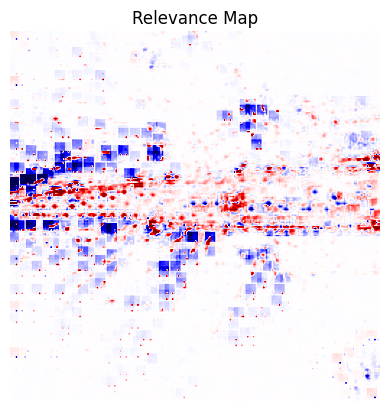

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

relevance_map = relevance.sum(axis=np.argmax(np.asarray(relevance.shape) == 3))[0]

# Take 99th percentile
vmax = np.percentile(np.abs(relevance_map), 99)

# Clip and normalize
relevance_map = np.clip(relevance_map, -vmax, vmax)
relevance_map /= vmax

# Plot
plt.imshow(relevance_map, cmap="seismic", clim=(-1, 1))
plt.title("Relevance Map")
plt.axis("off")
plt.show()
